In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16246, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 16246 (delta 53), reused 68 (delta 20), pack-reused 16103
Receiving objects: 100% (16246/16246), 15.06 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (11084/11084), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.2 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/airport security check.v1i.yolov5pytorch.zip"

Archive:  /content/drive/MyDrive/airport security check.v1i.yolov5pytorch.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/000016401024647_jpg.rf.858d208a8ae4b19eff26dfc5dbc89ba8.jpg  
 extracting: test/images/000217601015961_jpg.rf.544212e4764d0dfd5f80535b8ebe76a4.jpg  
 extracting: test/images/000378101017566_jpg.rf.b78f0beb4892387f881538ad1301530d.jpg  
 extracting: test/images/001105801007843_jpg.rf.99b5082d2b2328c0db4141764a998082.jpg  
 extracting: test/images/001639201013177_jpg.rf.a60010a6bcf918f9e8e533ae8dd65d07.jpg  
 extracting: test/images/001811901024102_jpg.rf.25397dd9af476ba4ab8f0a3527dcedad.jpg  
 extracting: test/images/001897901028177_jpg.rf.b9a47a25d5162b95cbbd3dc37aaffa08.jpg  
 extracting: test/images/002138401030567_jpg.rf.17c83a3b6d1f84a39a7c0f90ac4c1780.jpg  
 extracting: test/images/002707701005092_jpg.rf.07e31274e667b58fefc

In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat /content/yolov5/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['battary', 'liquide', 'machine', 'metal-battery-machine-liquid']

roboflow:
  workspace: airportxray
  project: airport-security-check
  version: 1
  license: Public Domain
  url: https://universe.roboflow.com/airportxray/airport-security-check/dataset/1

In [ ]:
# define number of classes based on YAML
import yaml
with open("/content/yolov5/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
num_classes

'4'

In [ ]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data ./data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-01-08 04:19:36.833277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 04:19:36.833330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 04:19:36.835823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 04:19:38.305677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=F

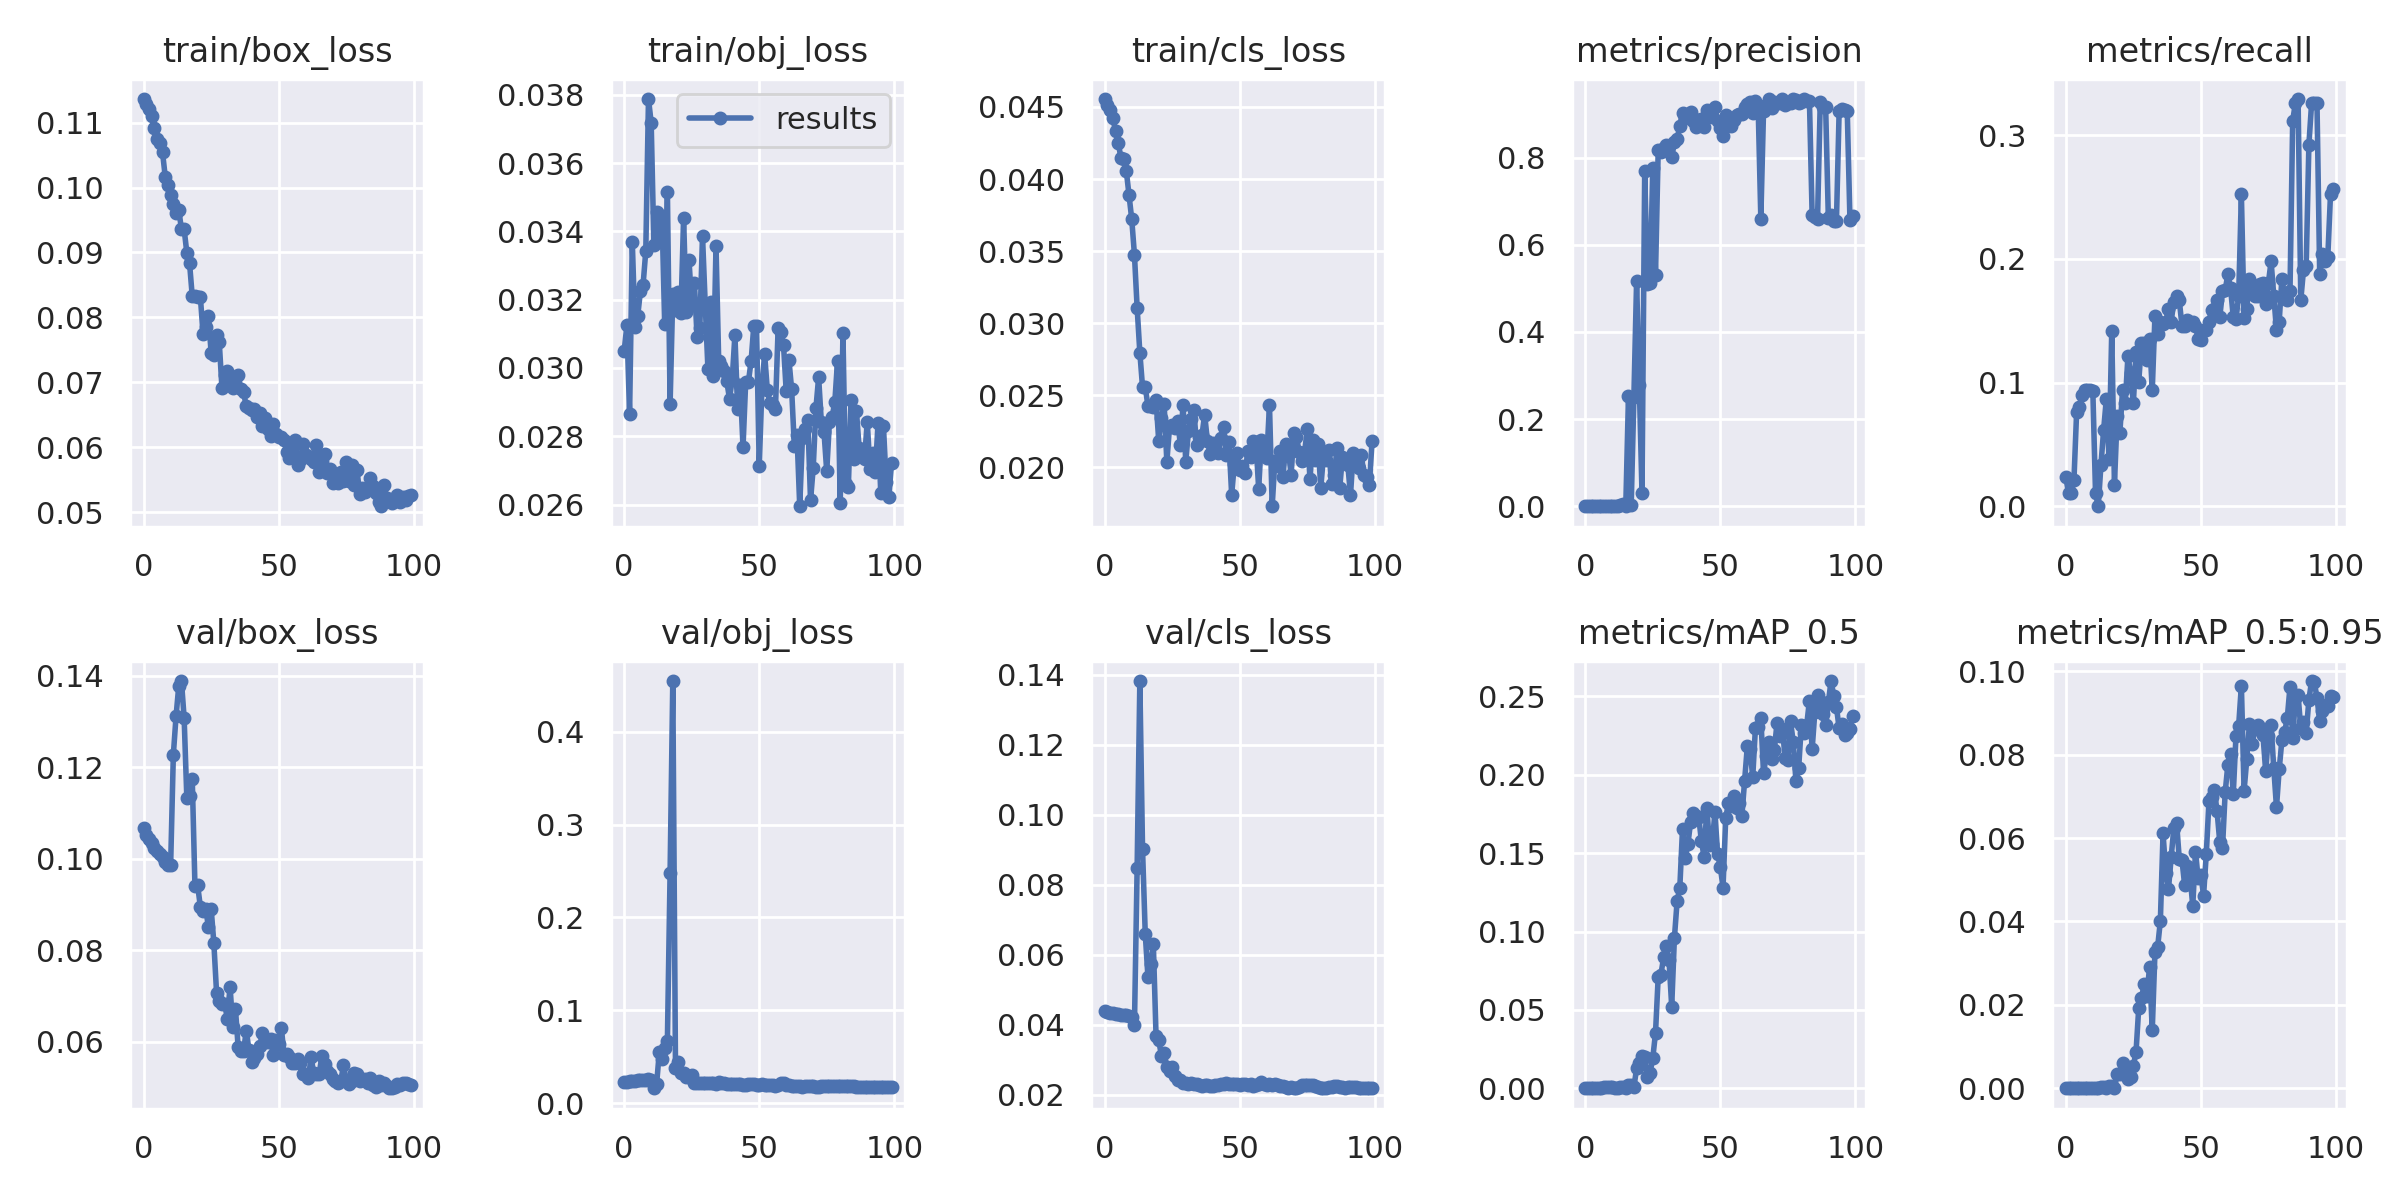

In [ ]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

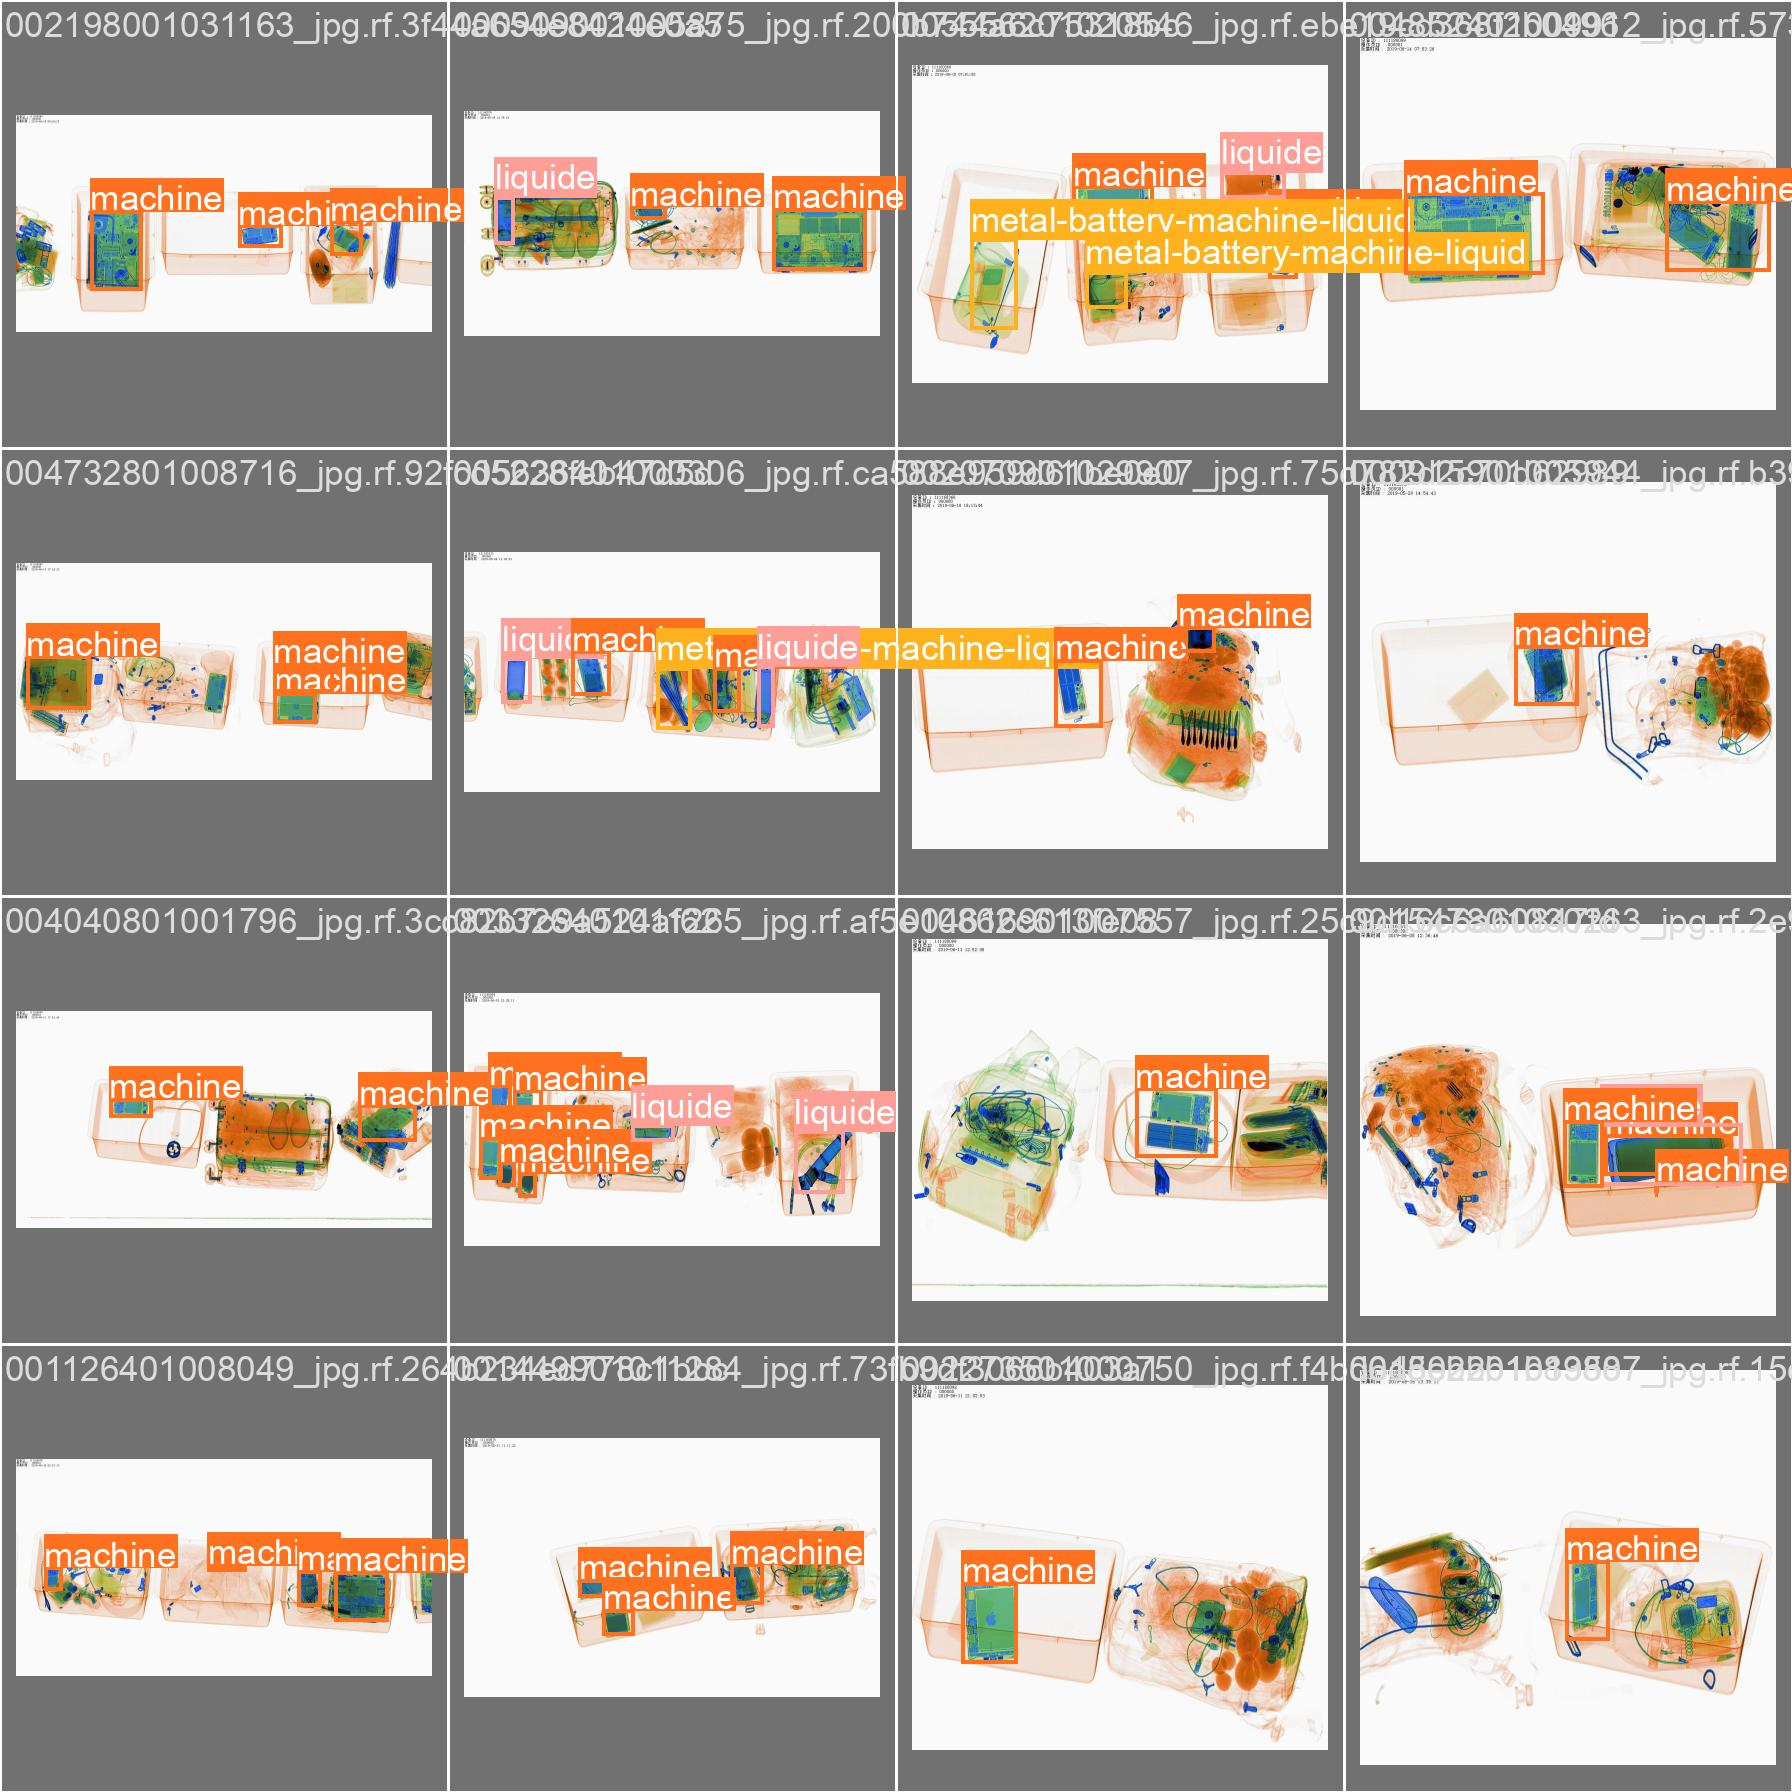

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


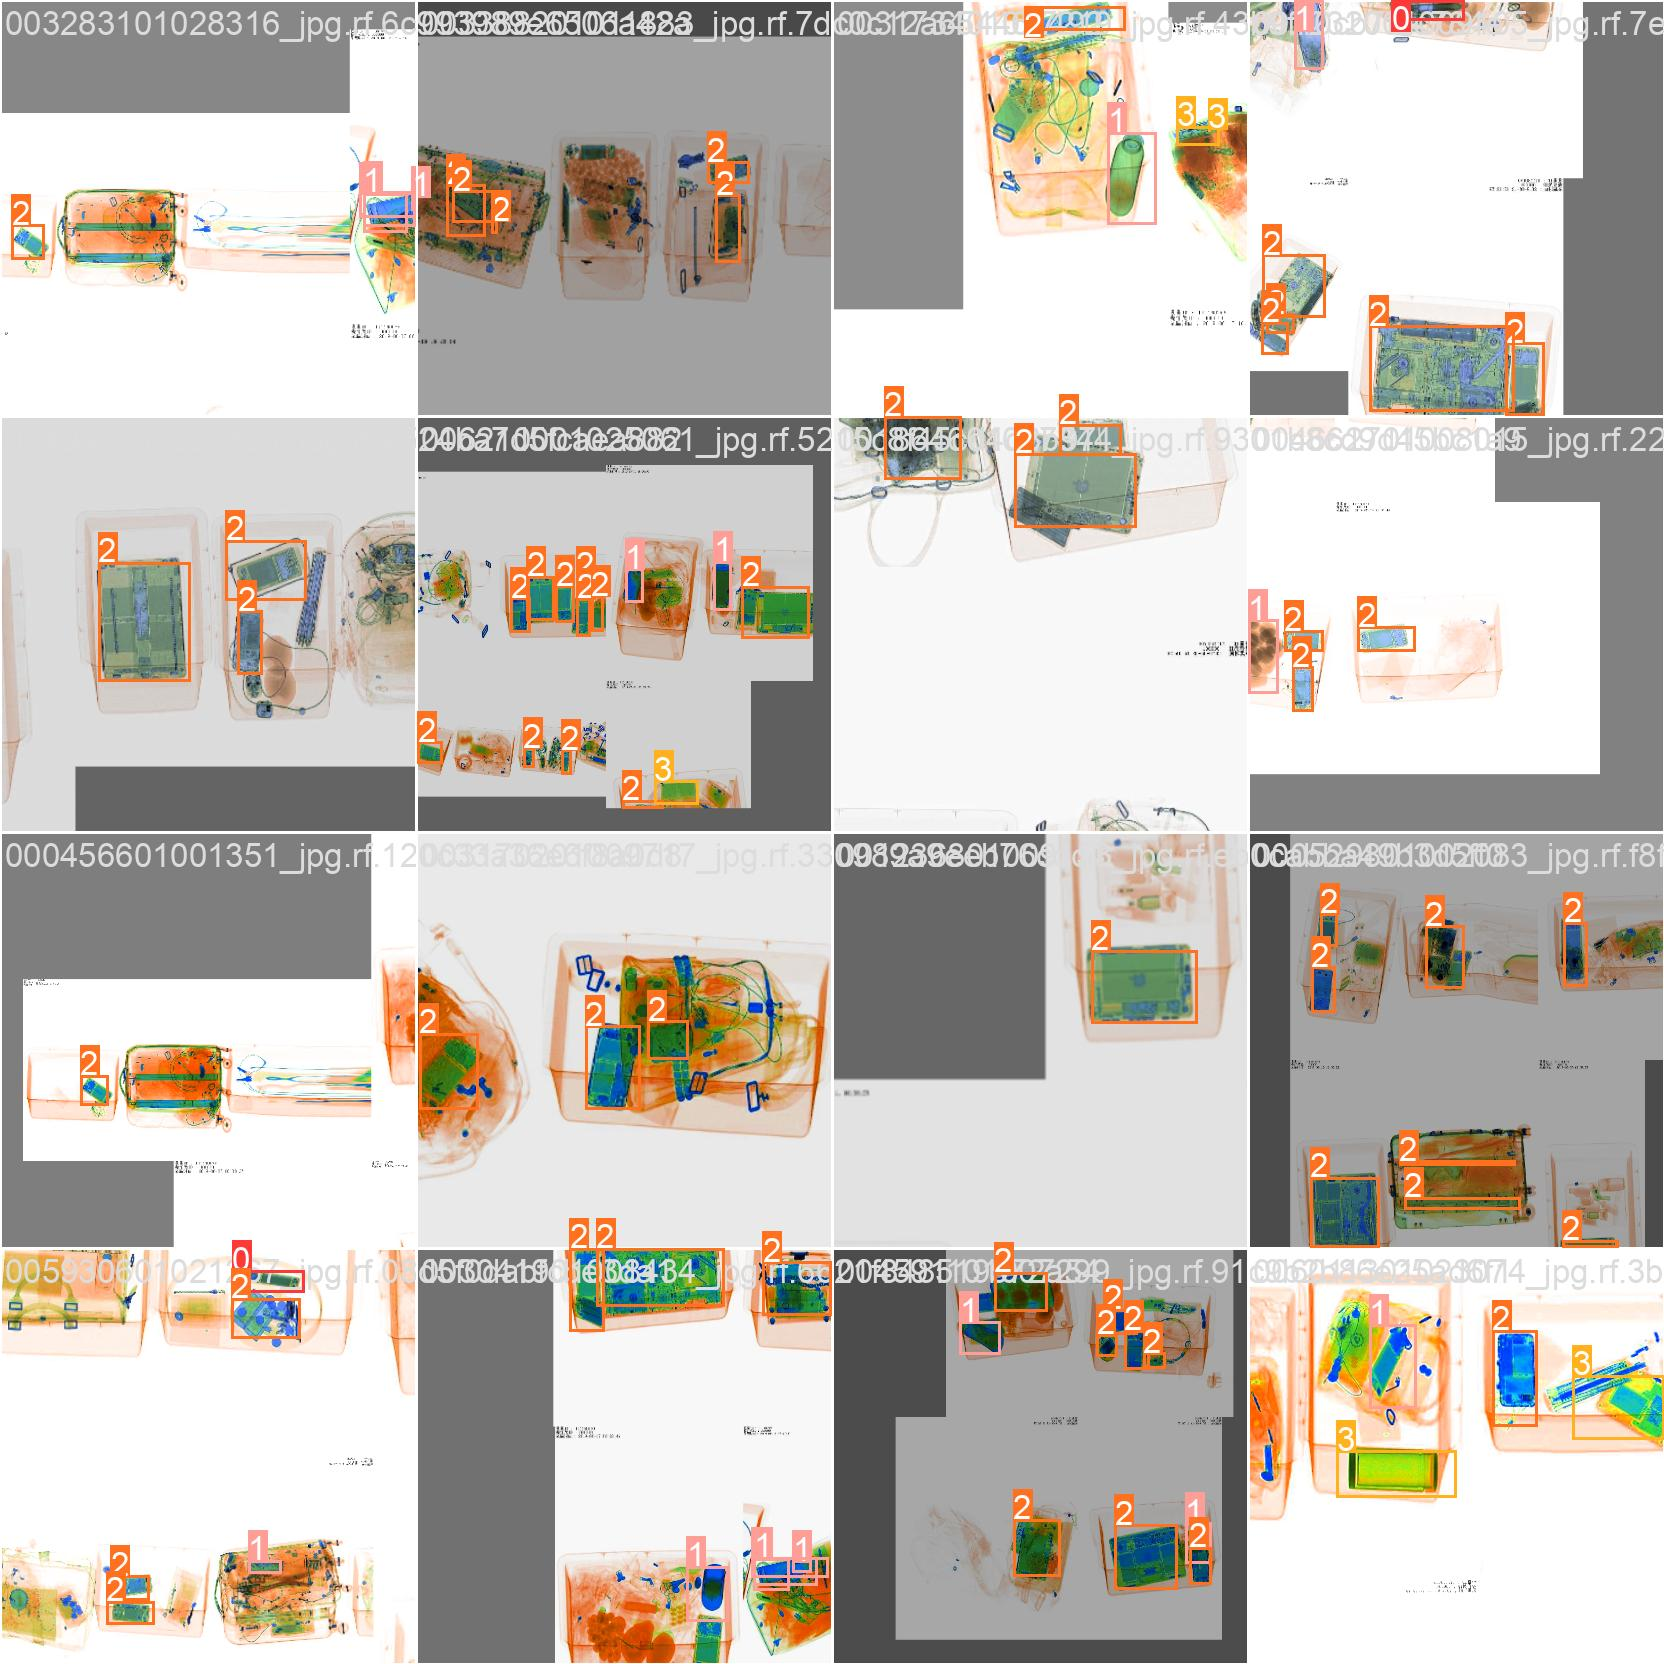

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [ ]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ./test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=./test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7254609 parameters, 0 gradients
image 1/20 /content/yolov5/test/images/000016401024647_jpg.rf.858d208a8ae4b19eff26dfc5dbc89ba8.jpg: 416x352 2 machines, 51.6ms
image 2/20 /content/yolov5/test/images/000217601015961_jpg.rf.544212e4764d0dfd5f80535b8ebe76a4.jpg: 224x416 1 machine, 76.3ms
image 3/20 /content/yolov5/test/images/000378101017566_jpg.rf.b78f0beb489238

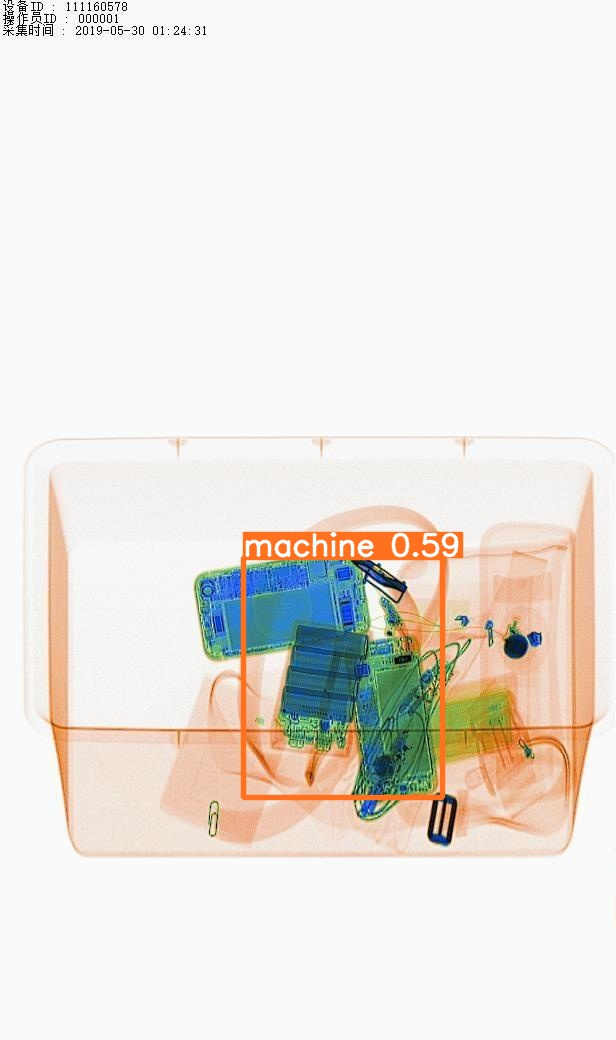

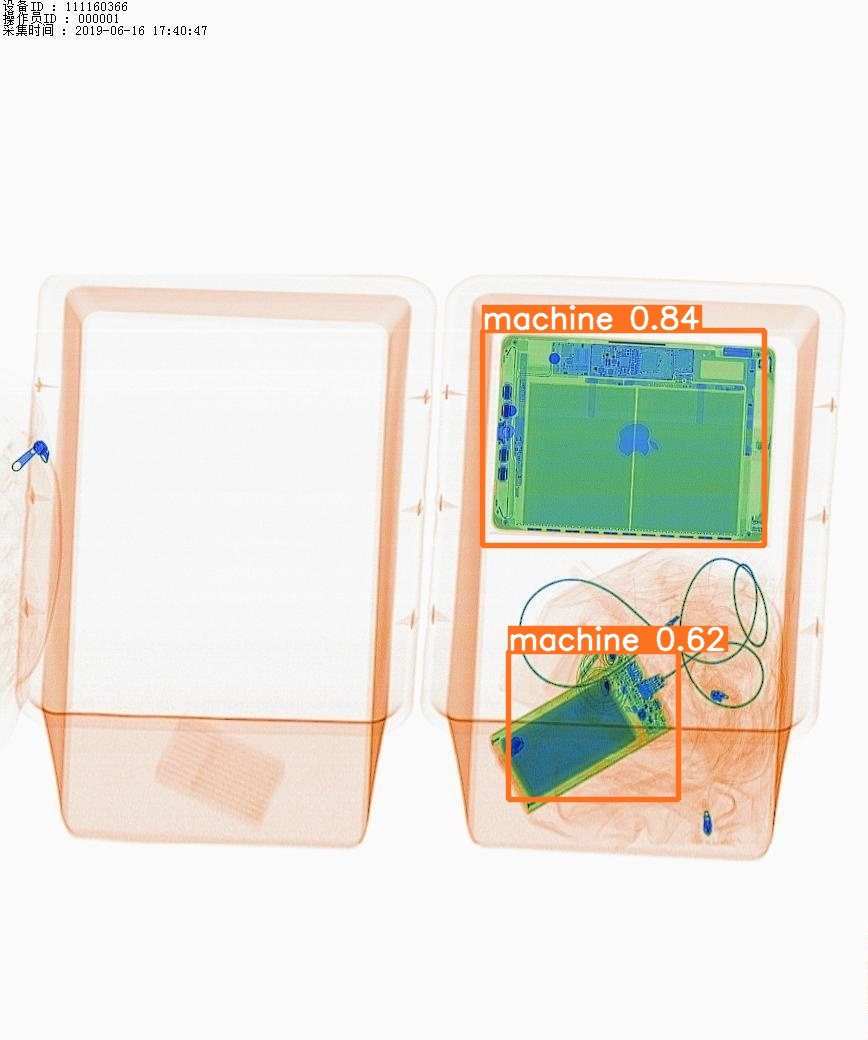

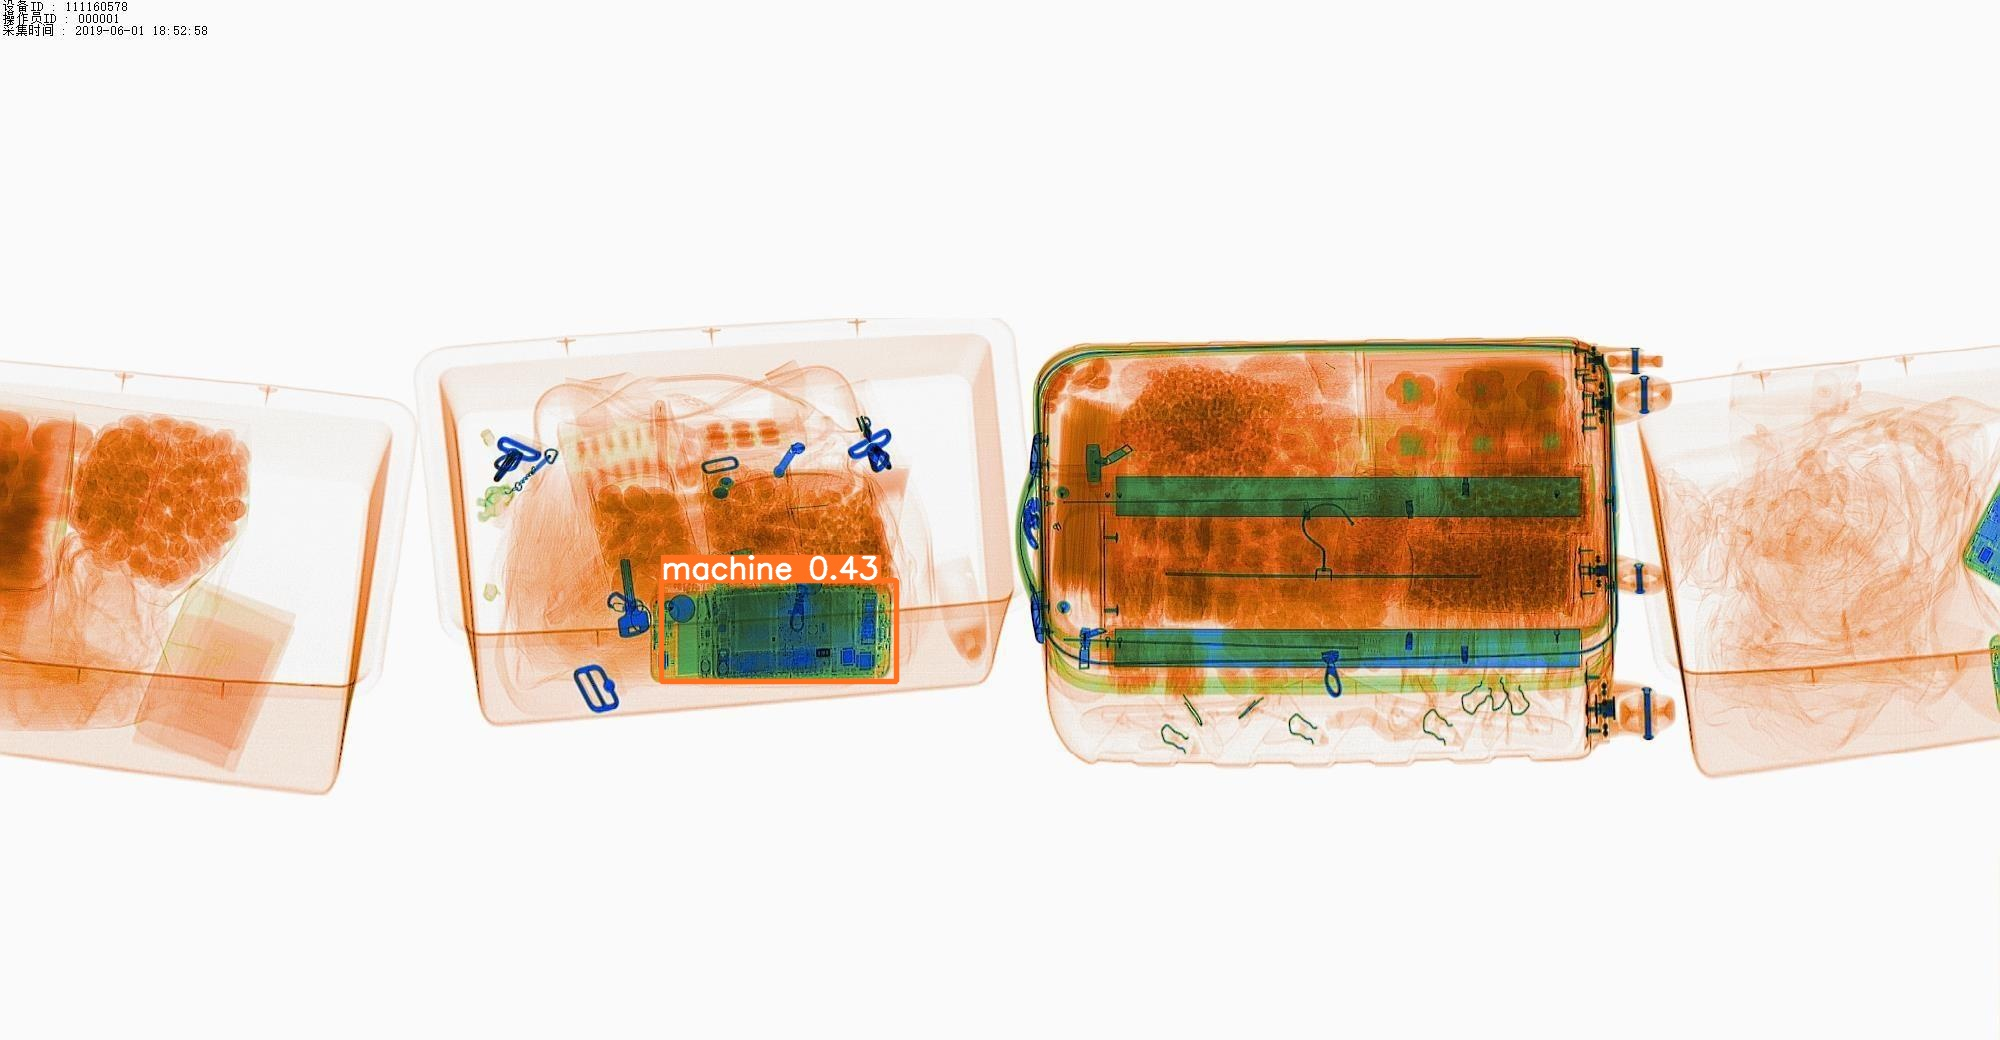

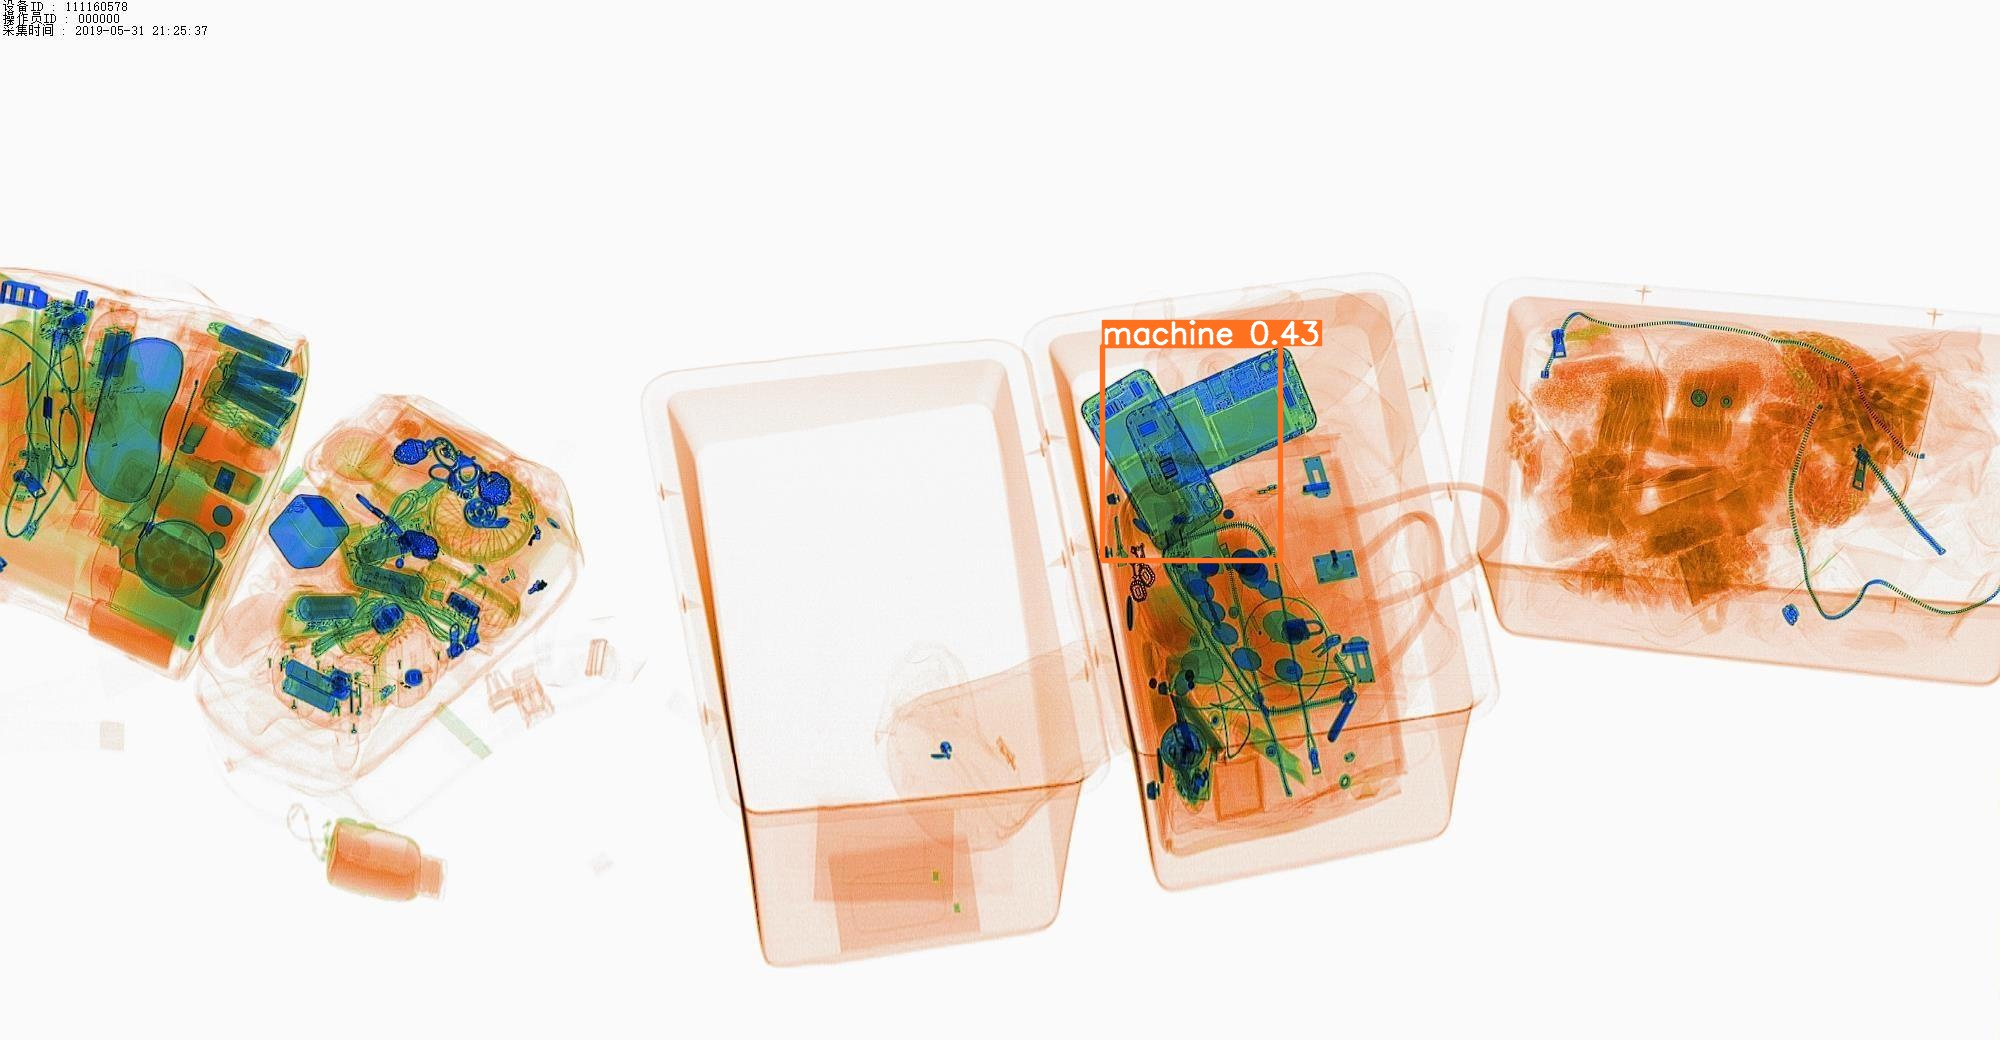

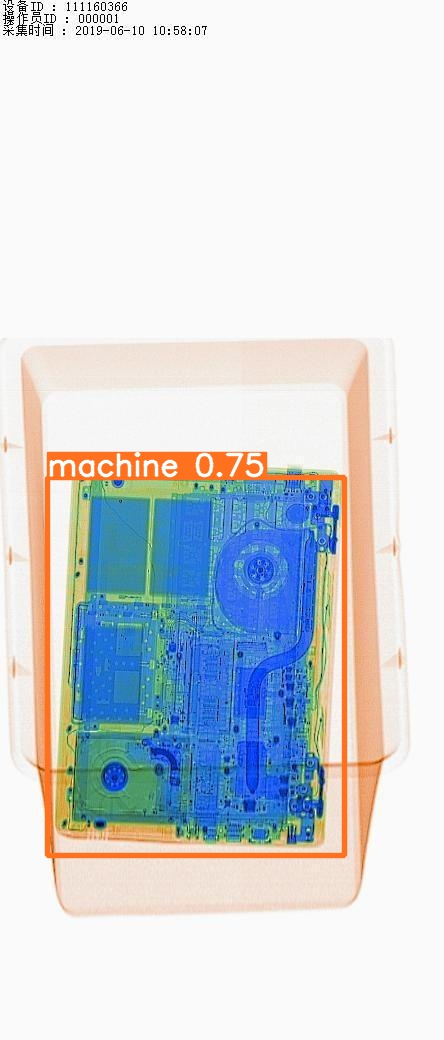

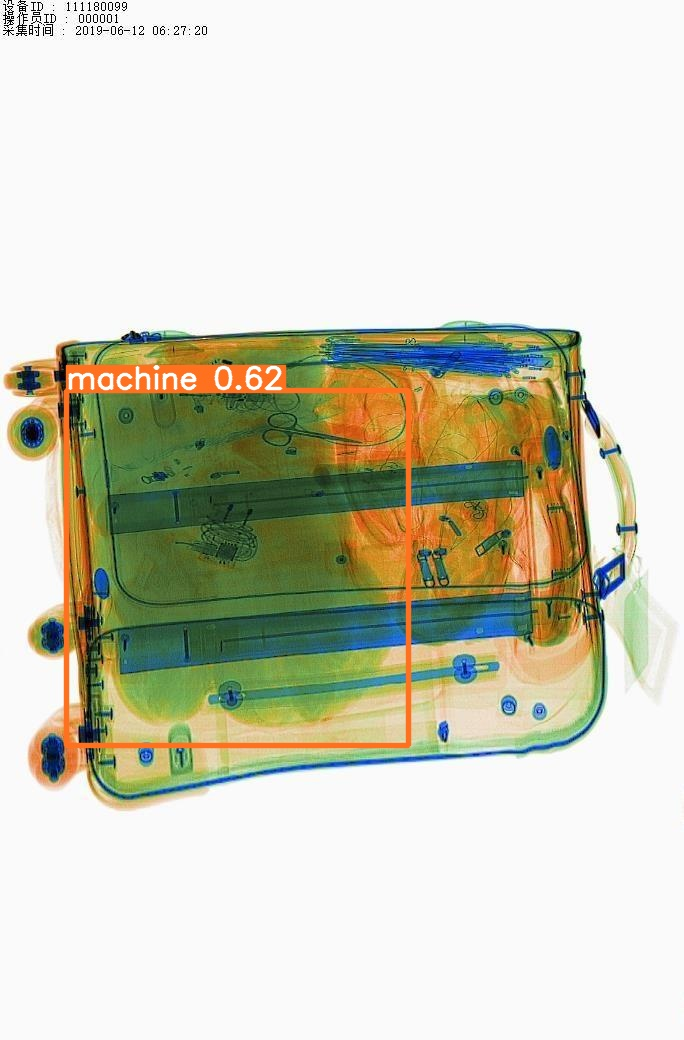

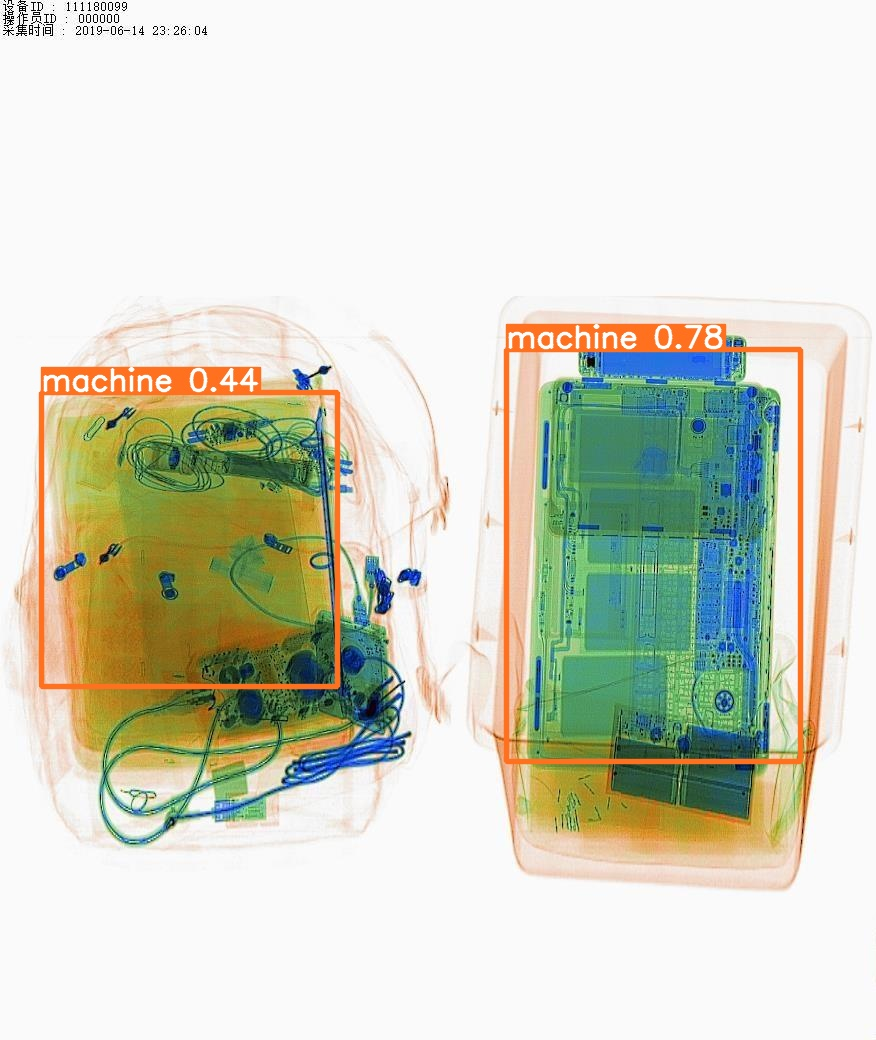

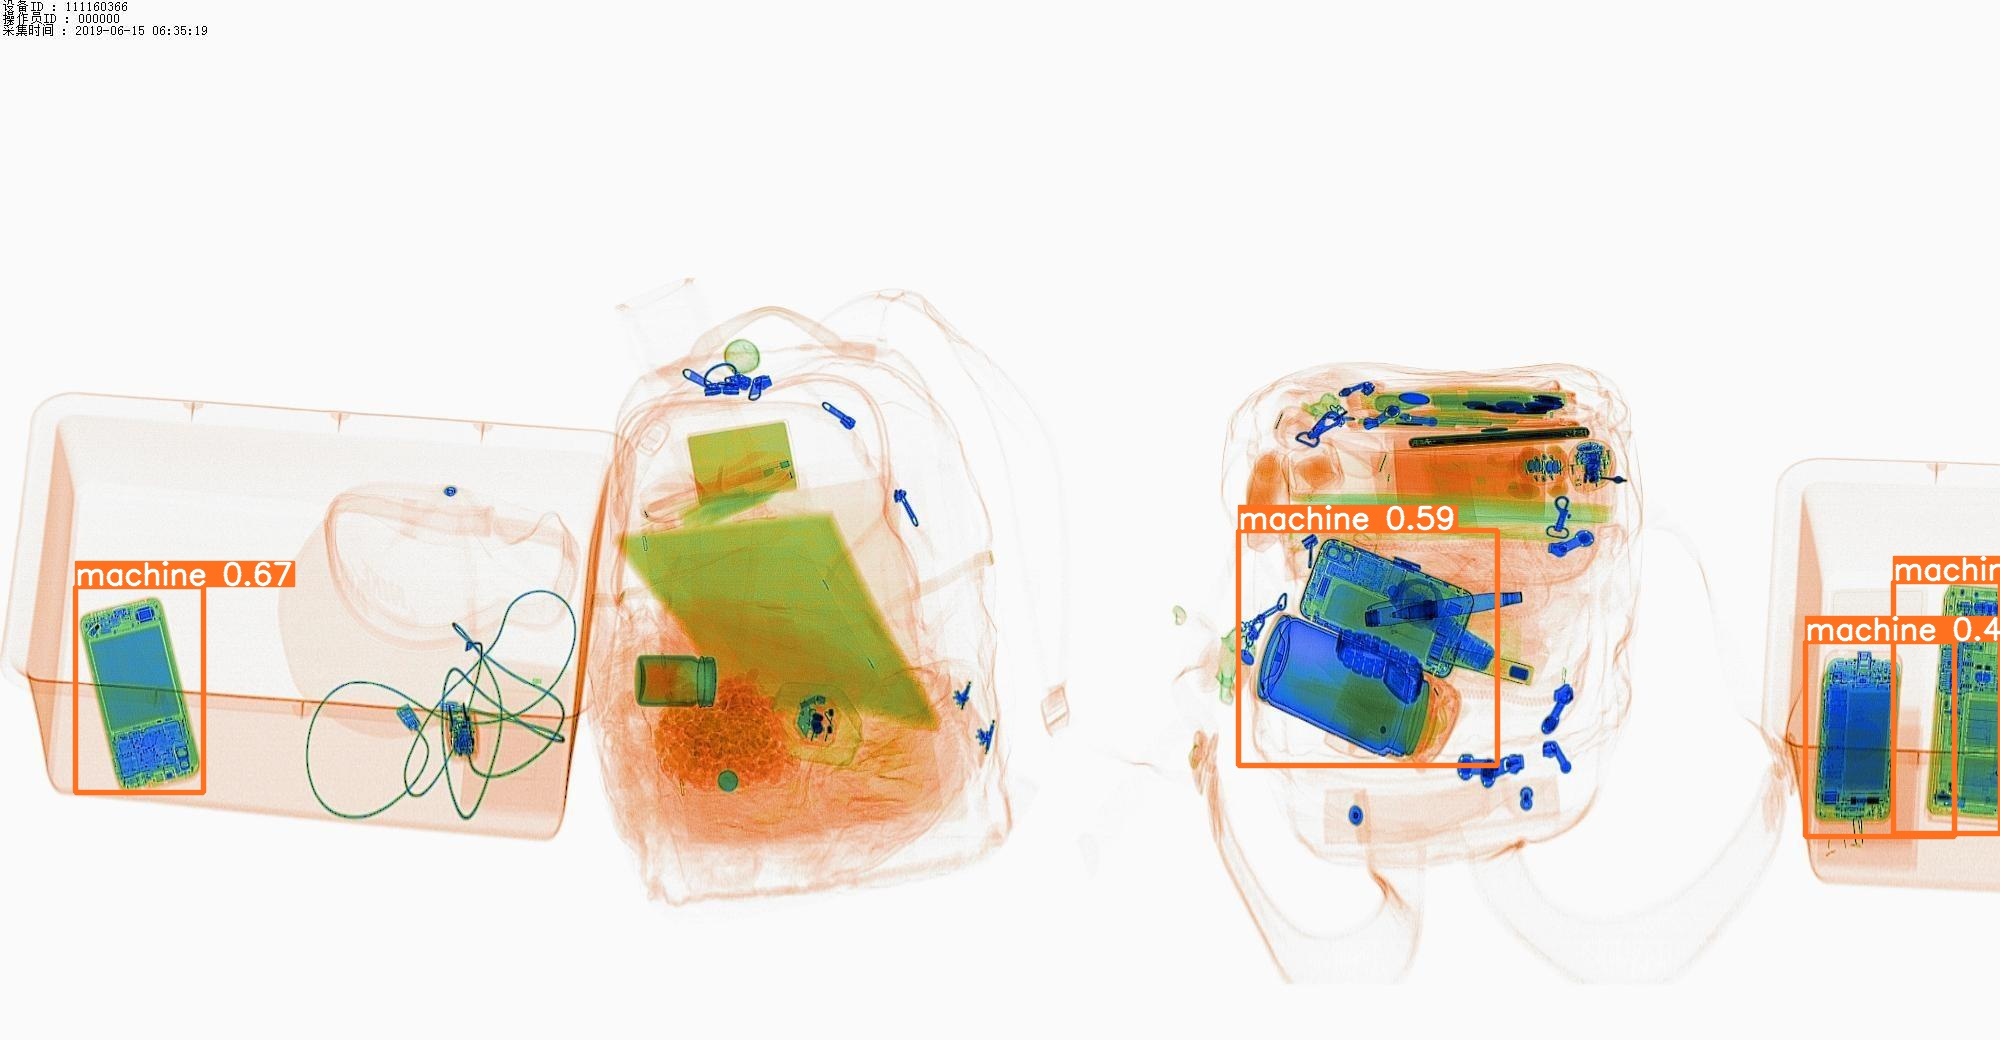

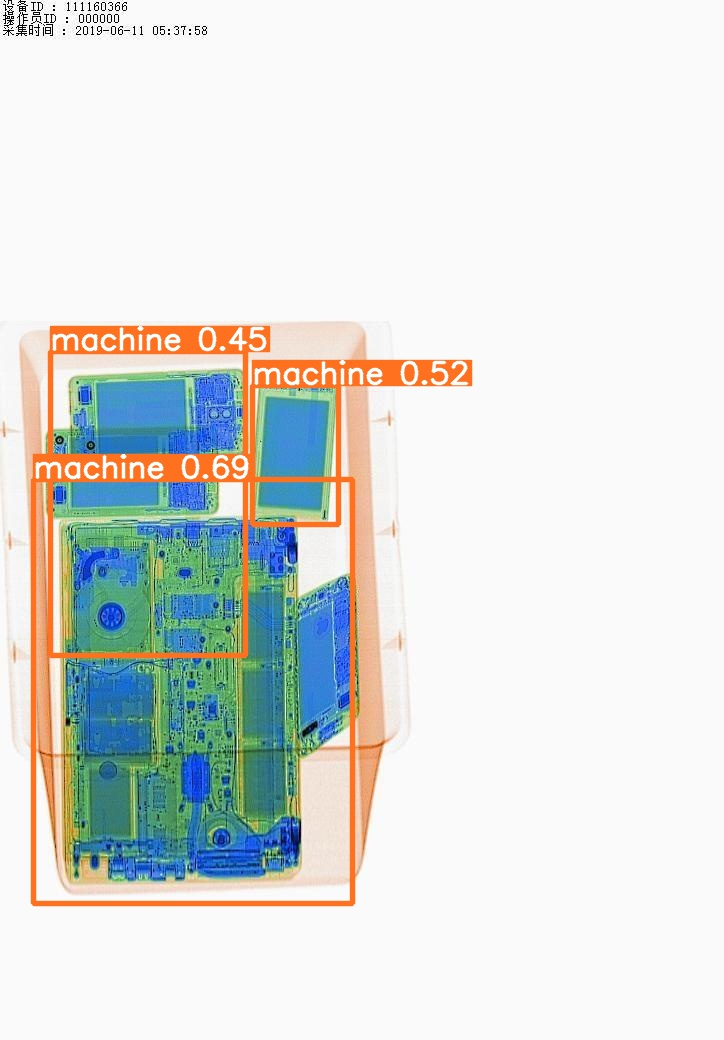

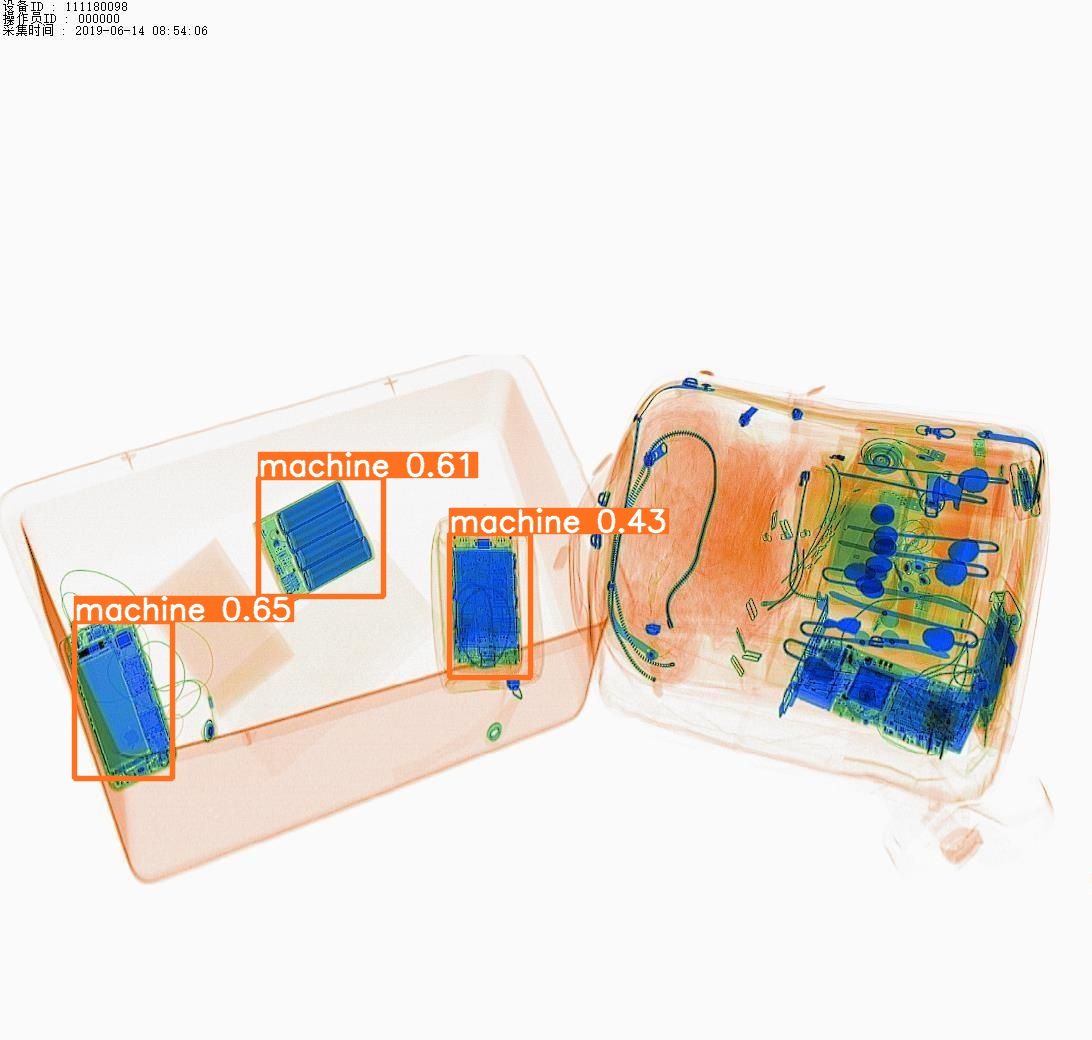

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp2/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))